In [1]:
from sqlalchemy import create_engine
import pandas as pd
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Input, Dense
from datetime import datetime
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestRegressor

In [3]:
########### CONNECT TO ThalesStockPredictor SQLServer DB

# Define connection string
connStr = 'mssql+pyodbc://@MSI/ThalesStockPredictor?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server'

# Create SQLAlchemy engine
engine = create_engine(connStr)

# Define the query
query = """
SELECT * FROM vw_COMBINED_MODEL
ORDER BY FK_DT_Date desc
"""

# Execute the query and assign the result to a pandas DataFrame
Model_Data = pd.read_sql(query, engine)

# Close the SQL Server Connection
engine.dispose()

In [4]:
# View the data
Model_Data

,FK_DT_Date,THA_Open,THA_High,THA_Low,THA_Close,THA_Adj_Close,THA_Volume,THA_NextDay_Close,SPI_Open,SPI_High,...,SPI_SMA,SPI_UpperBand,SPI_LowerBand,FRA_SMA,FRA_UpperBand,FRA_LowerBand,THA_OBV,EUR_OBV,SPI_OBV,FRA_OBV
0,2024-03-05,145.000000,151.050003,143.350006,150.899994,150.899994,669756.0,NaN,5110.520020,5114.540039,...,5038.216455,5149.478140,4926.954770,7813.302490,8071.131062,7555.473919,21392734.0,2.318764e+10,1.295084e+12,8.148700e+09
1,2024-03-04,136.000000,138.600006,135.850006,138.350006,138.350006,351633.0,150.899994,5130.990234,5149.669922,...,5032.122949,5150.409361,4913.836537,7798.610010,8061.207936,7536.012083,20722978.0,2.318764e+10,1.296771e+12,8.148700e+09
2,2024-03-01,137.500000,138.250000,135.399994,135.399994,135.399994,236008.0,138.350006,5098.509766,5140.330078,...,5023.505933,5136.468663,4910.543202,7780.287500,8047.620766,7512.954234,20371345.0,2.318886e+10,1.301530e+12,8.104148e+09
3,2024-02-29,137.250000,137.300003,135.699997,137.050003,137.050003,984695.0,135.399994,5085.359863,5104.990234,...,5011.961426,5123.232730,4900.690122,7763.191992,8032.810869,7493.573116,20607353.0,2.310308e+10,1.296782e+12,8.053039e+09
4,2024-02-28,137.000000,137.149994,135.850006,136.600006,136.600006,186668.0,137.050003,5067.200195,5077.370117,...,4999.430420,5126.106344,4872.754496,7746.257983,8014.985481,7477.530486,19622658.0,2.300034e+10,1.291562e+12,8.161566e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,2000-01-07,33.500000,35.119999,33.349998,35.049999,19.815237,506662.0,35.200001,1403.449951,1441.469971,...,1420.333984,1472.471683,1368.196286,5611.762012,5993.606240,5229.917784,-180815.0,-8.448290e+07,2.394000e+09,0.000000e+00
6212,2000-01-06,33.000000,33.400002,32.599998,33.160000,18.746742,178098.0,35.049999,1402.109985,1411.900024,...,1415.049988,1468.714715,1361.385261,5629.800049,6060.764238,5198.835860,-687477.0,-1.405418e+08,1.168800e+09,0.000000e+00
6213,2000-01-05,33.599998,34.599998,32.000000,32.000000,18.090946,429936.0,33.160000,1399.420044,1413.270020,...,1418.916667,1481.853345,1355.979989,5689.696777,6128.436294,5250.957260,-865575.0,-9.936120e+07,7.650003e+07,0.000000e+00
6214,2000-01-04,35.950001,35.950001,33.099998,33.750000,19.080296,435639.0,32.000000,1455.219971,1455.219971,...,1427.320007,1506.233021,1348.406994,5794.695068,6141.672504,5447.717633,-435639.0,-4.667840e+07,-1.009000e+09,0.000000e+00


In [5]:
# Copy original data frame for normalization
Model_ML = Model_Data.copy()

In [6]:
Model_ML

,FK_DT_Date,THA_Open,THA_High,THA_Low,THA_Close,THA_Adj_Close,THA_Volume,THA_NextDay_Close,SPI_Open,SPI_High,...,SPI_SMA,SPI_UpperBand,SPI_LowerBand,FRA_SMA,FRA_UpperBand,FRA_LowerBand,THA_OBV,EUR_OBV,SPI_OBV,FRA_OBV
0,2024-03-05,145.000000,151.050003,143.350006,150.899994,150.899994,669756.0,NaN,5110.520020,5114.540039,...,5038.216455,5149.478140,4926.954770,7813.302490,8071.131062,7555.473919,21392734.0,2.318764e+10,1.295084e+12,8.148700e+09
1,2024-03-04,136.000000,138.600006,135.850006,138.350006,138.350006,351633.0,150.899994,5130.990234,5149.669922,...,5032.122949,5150.409361,4913.836537,7798.610010,8061.207936,7536.012083,20722978.0,2.318764e+10,1.296771e+12,8.148700e+09
2,2024-03-01,137.500000,138.250000,135.399994,135.399994,135.399994,236008.0,138.350006,5098.509766,5140.330078,...,5023.505933,5136.468663,4910.543202,7780.287500,8047.620766,7512.954234,20371345.0,2.318886e+10,1.301530e+12,8.104148e+09
3,2024-02-29,137.250000,137.300003,135.699997,137.050003,137.050003,984695.0,135.399994,5085.359863,5104.990234,...,5011.961426,5123.232730,4900.690122,7763.191992,8032.810869,7493.573116,20607353.0,2.310308e+10,1.296782e+12,8.053039e+09
4,2024-02-28,137.000000,137.149994,135.850006,136.600006,136.600006,186668.0,137.050003,5067.200195,5077.370117,...,4999.430420,5126.106344,4872.754496,7746.257983,8014.985481,7477.530486,19622658.0,2.300034e+10,1.291562e+12,8.161566e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,2000-01-07,33.500000,35.119999,33.349998,35.049999,19.815237,506662.0,35.200001,1403.449951,1441.469971,...,1420.333984,1472.471683,1368.196286,5611.762012,5993.606240,5229.917784,-180815.0,-8.448290e+07,2.394000e+09,0.000000e+00
6212,2000-01-06,33.000000,33.400002,32.599998,33.160000,18.746742,178098.0,35.049999,1402.109985,1411.900024,...,1415.049988,1468.714715,1361.385261,5629.800049,6060.764238,5198.835860,-687477.0,-1.405418e+08,1.168800e+09,0.000000e+00
6213,2000-01-05,33.599998,34.599998,32.000000,32.000000,18.090946,429936.0,33.160000,1399.420044,1413.270020,...,1418.916667,1481.853345,1355.979989,5689.696777,6128.436294,5250.957260,-865575.0,-9.936120e+07,7.650003e+07,0.000000e+00
6214,2000-01-04,35.950001,35.950001,33.099998,33.750000,19.080296,435639.0,32.000000,1455.219971,1455.219971,...,1427.320007,1506.233021,1348.406994,5794.695068,6141.672504,5447.717633,-435639.0,-4.667840e+07,-1.009000e+09,0.000000e+00


In [7]:
# Convert 'FK_DT_Date' to UNIX Epoch (numeric date)
Model_ML['FK_DT_Date'] = pd.to_datetime(Model_ML['FK_DT_Date']).astype('int64') // 10**9

# Remove rows with NA values (equivalent to na.omit in R)
Model_ML.dropna(inplace=True)

# Reset row names (equivalent to removing row names in R)
Model_ML.reset_index(drop=True)

Model_ML

,FK_DT_Date,THA_Open,THA_High,THA_Low,THA_Close,THA_Adj_Close,THA_Volume,THA_NextDay_Close,SPI_Open,SPI_High,...,SPI_SMA,SPI_UpperBand,SPI_LowerBand,FRA_SMA,FRA_UpperBand,FRA_LowerBand,THA_OBV,EUR_OBV,SPI_OBV,FRA_OBV
1,1709510400,136.000000,138.600006,135.850006,138.350006,138.350006,351633.0,150.899994,5130.990234,5149.669922,...,5032.122949,5150.409361,4913.836537,7798.610010,8061.207936,7536.012083,20722978.0,2.318764e+10,1.296771e+12,8.148700e+09
4,1709078400,137.000000,137.149994,135.850006,136.600006,136.600006,186668.0,137.050003,5067.200195,5077.370117,...,4999.430420,5126.106344,4872.754496,7746.257983,8014.985481,7477.530486,19622658.0,2.300034e+10,1.291562e+12,8.161566e+09
5,1708992000,138.899994,139.100006,136.000000,136.850006,136.850006,254221.0,136.600006,5074.600098,5080.689941,...,4992.190942,5118.492300,4865.889585,7731.375977,7984.059230,7478.692723,19809326.0,2.294370e+10,1.295351e+12,8.108808e+09
6,1708905600,135.500000,139.250000,135.050003,138.750000,138.750000,304159.0,136.850006,5093.000000,5097.660156,...,4984.678442,5107.263494,4862.093391,7717.829492,7949.717954,7485.941031,20063547.0,2.288397e+10,1.291425e+12,8.058411e+09
9,1708473600,135.300003,135.300003,132.649994,134.850006,134.850006,238055.0,134.250000,4963.029785,4983.209961,...,4955.094482,5063.497564,4846.691400,7664.382007,7830.537080,7498.226933,19747860.0,2.266789e+10,1.287385e+12,7.983094e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6207,947721600,36.000000,36.750000,34.000000,34.000000,19.221630,519684.0,37.400002,1432.250000,1454.199951,...,1431.084446,1478.000940,1384.167951,5614.952257,5887.180144,5342.724370,-890813.0,-3.567400e+06,2.500600e+09,0.000000e+00
6208,947635200,33.549999,35.139999,33.549999,34.889999,19.724779,186958.0,34.000000,1438.560059,1442.599976,...,1428.759995,1476.648518,1380.871471,5612.666260,5903.320486,5322.012034,-371129.0,-5.168360e+07,1.470200e+09,0.000000e+00
6209,947548800,35.189999,35.189999,33.750000,35.000000,19.786970,205261.0,34.889999,1457.599976,1458.660034,...,1428.261422,1479.897156,1376.625688,5616.975725,5929.811982,5304.139469,-184171.0,-8.636670e+07,2.444800e+09,0.000000e+00
6210,947462400,35.500000,35.490002,34.700001,35.200001,19.900040,201905.0,35.000000,1441.469971,1464.359985,...,1426.544983,1482.227186,1370.862780,5617.488363,5960.170428,5274.806297,21090.0,-4.247670e+07,3.458800e+09,0.000000e+00


In [8]:
# Set random seed for reproducibility
seed = 123

# Proportion for training set
train_prop = 0.8

# Split data into training and initial test sets
train_data, initial_test_data = train_test_split(Model_ML, test_size=1-train_prop, random_state=seed)

# Proportion for validation set (from the initial test set)
val_prop = 0.5

# Split initial test data into validation and testing sets
validate_data, test_data = train_test_split(initial_test_data, test_size=val_prop, random_state=seed)

# Reset row indices
train_data.reset_index(drop=True, inplace=True)
validate_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [9]:
# Feature Importance for Un-Normalized train_data dataframe
# Separate features and target variable
features = train_data.drop("THA_NextDay_Close", axis=1)  # Replace "target_column" with your target
target = train_data["THA_NextDay_Close"]

# Create the Random Forest model for regression
RFmodel = RandomForestRegressor(n_estimators=500)  # using 500 as there is a chance of overfitting n_estimators as needed

# Train the model
RFmodel.fit(features, target)



RandomForestRegressor(n_estimators=500)

In [17]:
# Get feature importances
importance = RFmodel.feature_importances_
feature_names = features.columns
sorted_idx = importance.argsort()[::-1]  # Sort features by importance (descending)
sorted_features = feature_names[sorted_idx]
sorted_importance = importance[sorted_idx]

# print sorted importance
print("Feature Importances (without scientific notation):\n")
for feature, importance in zip(sorted_features, sorted_importance):
    print(f"{feature}: {importance:.8f}") 

# Set a threshold for minimum importance (adjust as needed)
importance_threshold = 0.00001500

# Filter features and importance based on threshold
filtered_features = sorted_features[sorted_importance >= importance_threshold]
filtered_importance = sorted_importance[sorted_importance >= importance_threshold]

# Print or visualize importance
print("Sorted features by importance:\n", filtered_features)


Feature Importances (without scientific notation):

THA_Close: 0.89900860
THA_High: 0.06621280
THA_Adj_Close: 0.01828385
THA_Low: 0.01196835
THA_Open: 0.00259879
THA_MA_7: 0.00025970
THA_MA_180: 0.00017731
THA_MA_90: 0.00017180
THA_UpperBand: 0.00016363
FK_DT_Date: 0.00015634
EUR_MA_180: 0.00006176
THA_EMA26: 0.00005402
SPI_MA_180: 0.00003184
THA_SMA: 0.00003079
THA_MA_30: 0.00002996
THA_MACD: 0.00002535
THA_EMA12: 0.00002459
SPI_RSI_7: 0.00002419
EUR_RSI_7: 0.00002311
THA_Volume: 0.00002277
THA_RSI_180: 0.00002215
SPI_Volume: 0.00002204
SPI_RSI_90: 0.00002168
FRA_RSI_7: 0.00002052
THA_RSI_30: 0.00002015
THA_LowerBand: 0.00001995
EUR_Volume: 0.00001988
THA_RSI_7: 0.00001855
SPI_RSI_30: 0.00001828
SPI_MACD: 0.00001778
EUR_RSI_90: 0.00001738
FRA_RSI_30: 0.00001700
THA_OBV: 0.00001689
EUR_MACD: 0.00001650
EUR_RSI_180: 0.00001486
SPI_RSI_180: 0.00001471
EUR_RSI_30: 0.00001453
FRA_RSI_180: 0.00001437
THA_RSI_90: 0.00001371
FRA_Volume: 0.00001316
FRA_MA_180: 0.00001295
FRA_RSI_90: 0.00001282

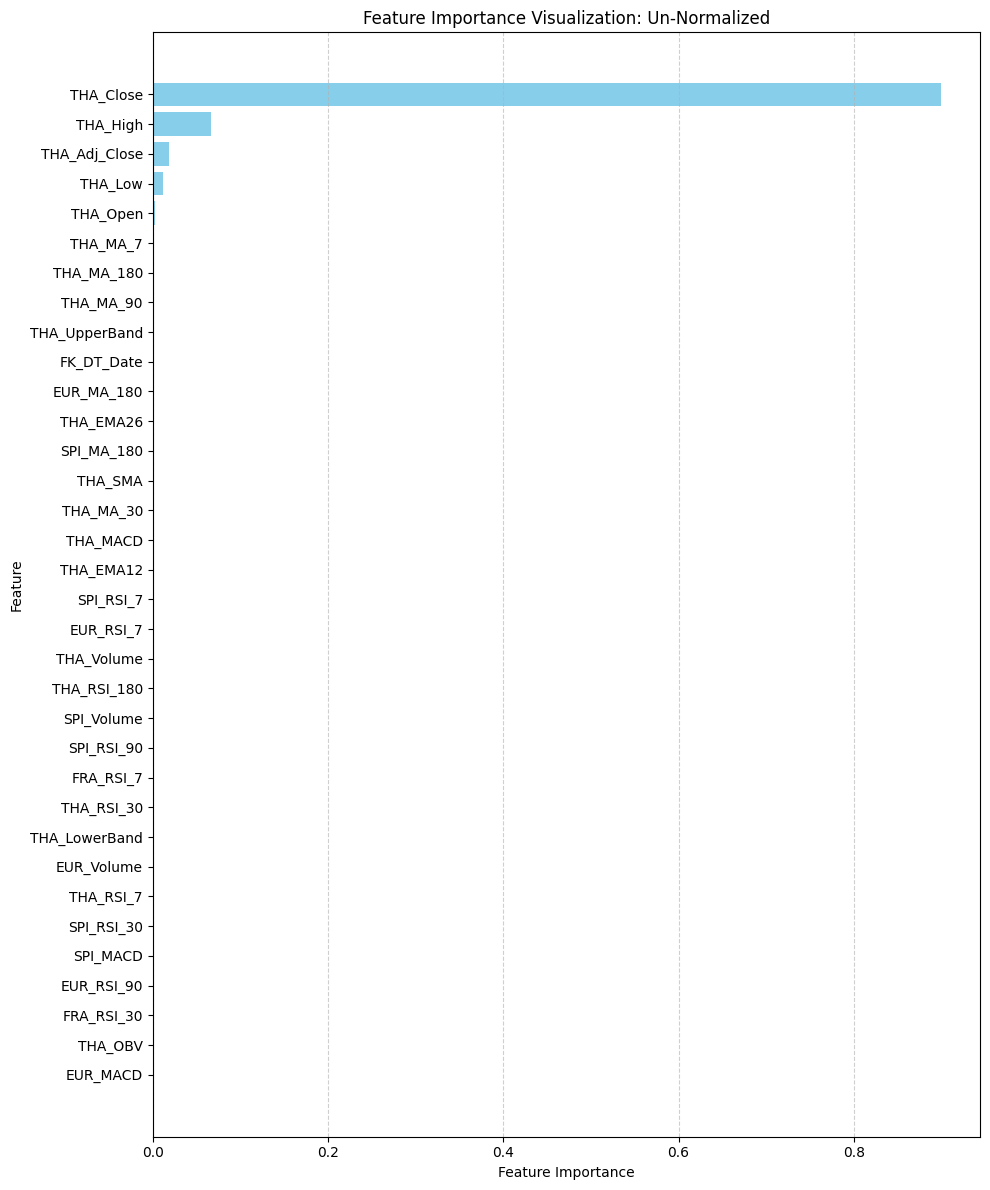

In [18]:
# Create a bar chart to visualize un-normalized feature importance

# Create the bar chart with filtered data
plt.figure(figsize=(10, 12))
plt.barh(filtered_features, filtered_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Visualization: Un-Normalized")
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [9]:
# Define your own `normalize()` function
def normalize(x):
    num = x - x.min()
    denom = x.max() - x.min()
    return num / denom

# Create a list of column names to exclude
exclude_columns = ["FK_DT_Date", "THA_NextDay_Close"]

# Normalize columns in the training dataset (excluding specified columns)
train_data.loc[:, ~train_data.columns.isin(exclude_columns)] = train_data.loc[:, ~train_data.columns.isin(exclude_columns)].apply(normalize)

# Normalize columns in the validation dataset (excluding specified columns)
validate_data.loc[:, ~validate_data.columns.isin(exclude_columns)] = validate_data.loc[:, ~validate_data.columns.isin(exclude_columns)].apply(normalize)

# Normalize columns in the testing dataset (excluding specified columns)
test_data.loc[:, ~test_data.columns.isin(exclude_columns)] = test_data.loc[:, ~test_data.columns.isin(exclude_columns)].apply(normalize)

In [19]:
# Feature Importance for Normalized train_data dataframe
# Separate features and target variable
features_Norm = train_data.drop("THA_NextDay_Close", axis=1)  
target_Norm = train_data["THA_NextDay_Close"]

# Create the Random Forest model
RFmodel_Norm = RandomForestRegressor(n_estimators=500)  # using 5400 as there is a chance of overfitting 

# Train the model
RFmodel_Norm.fit(features_Norm, target_Norm)

RandomForestRegressor(n_estimators=500)

In [20]:

# Get feature importances
importance_Norm = RFmodel_Norm.feature_importances_

# Get feature importances
importance_Norm = RFmodel_Norm.feature_importances_
feature_names_Norm = features_Norm.columns
sorted_idx_Norm = importance_Norm.argsort()[::-1]  # Sort features by importance (descending)
sorted_features_Norm = feature_names_Norm[sorted_idx_Norm]
sorted_importance_Norm = importance_Norm[sorted_idx_Norm]

# print sorted importance
print("Feature Importances (without scientific notation):\n")
for feature_Norm, importance_Norm in zip(sorted_features_Norm, sorted_importance_Norm):
    print(f"{feature_Norm}: {importance_Norm:.8f}") 

# Set a threshold for minimum importance (adjust as needed)
importance_threshold = 0.00001500

# Filter features and importance based on threshold
filtered_features_Norm = sorted_features_Norm[sorted_importance_Norm >= importance_threshold]
filtered_importance_Norm = sorted_importance_Norm[sorted_importance_Norm >= importance_threshold]

# Print or visualize importance
print("Sorted features by importance:\n", filtered_features_Norm)

Feature Importances (without scientific notation):

THA_Close: 0.89528300
THA_High: 0.07175946
THA_Adj_Close: 0.01925398
THA_Low: 0.01090491
THA_Open: 0.00068554
THA_MA_7: 0.00040671
FK_DT_Date: 0.00019023
THA_UpperBand: 0.00017716
THA_MA_180: 0.00015848
THA_MA_90: 0.00015822
THA_MA_30: 0.00005004
THA_SMA: 0.00003841
EUR_MA_180: 0.00003786
EUR_MA_90: 0.00003425
THA_EMA12: 0.00002915
EUR_MA_30: 0.00002870
FRA_MA_30: 0.00002843
THA_MACD: 0.00002493
SPI_RSI_90: 0.00002488
SPI_RSI_7: 0.00002429
THA_RSI_180: 0.00002335
EUR_RSI_7: 0.00002287
THA_EMA26: 0.00002261
THA_Volume: 0.00002205
THA_LowerBand: 0.00002063
SPI_Volume: 0.00002032
FRA_RSI_7: 0.00002022
THA_RSI_30: 0.00001986
EUR_Volume: 0.00001935
SPI_RSI_30: 0.00001830
SPI_MACD: 0.00001766
EUR_RSI_90: 0.00001723
THA_RSI_7: 0.00001723
FRA_RSI_30: 0.00001675
THA_OBV: 0.00001598
EUR_MACD: 0.00001574
EUR_RSI_180: 0.00001551
SPI_RSI_180: 0.00001523
EUR_RSI_30: 0.00001462
FRA_RSI_180: 0.00001437
FRA_MA_180: 0.00001320
FRA_Volume: 0.00001316
TH

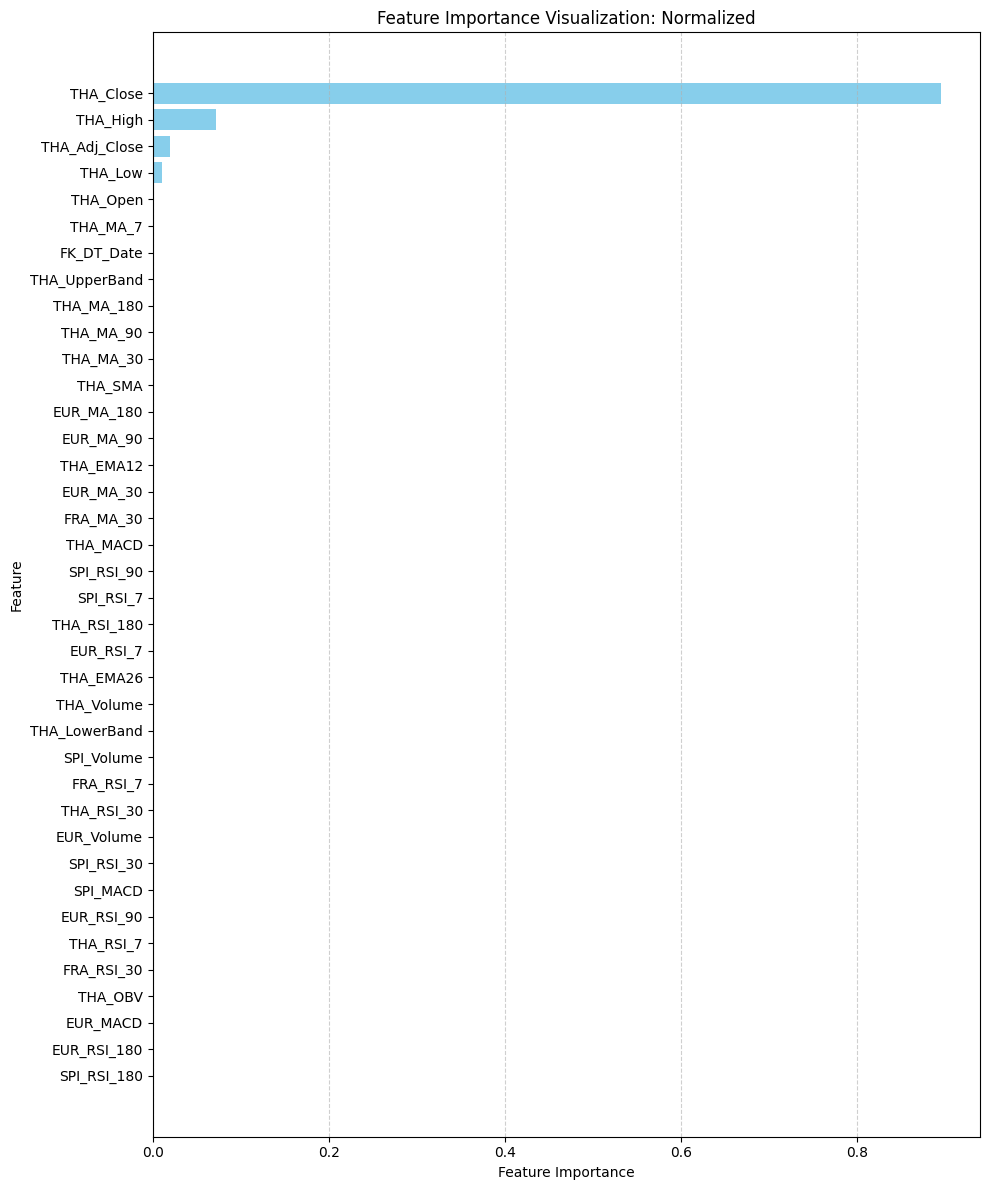

In [21]:
# Create a bar chart to visualize normalized feature importance

# Create the bar chart with filtered data
plt.figure(figsize=(10, 12))
plt.barh(filtered_features_Norm, filtered_importance_Norm, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Visualization: Normalized")
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [9]:
# Define features (X) and target (y)
X = train_data.drop(columns=['THA_NextDay_Close', 'FK_DT_Date'])
y = train_data['THA_NextDay_Close']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models (excluding ARIMA)
models = {
    'Random Forest': RandomForestRegressor(),
    'k-Nearest Neighbors': KNeighborsRegressor(),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Multi-layer Perceptron': MLPRegressor(max_iter=1000),
    'XGBoost': XGBRegressor(),
    'Support Vector Machine (Poly)': SVR(kernel='poly'),
    'Support Vector Machine (Radial)': SVR(kernel='rbf'),
    'Support Vector Machine (Linear)': SVR(kernel='linear')
}

# Function to calculate and print evaluation metrics
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{model_name}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")


# Loop through models, train, and evaluate
for model_name, model in models.items():
    model.fit(X_train, y_train)
    evaluate_model(model_name, model, X_test, y_test)


# Example LSTM implementation (adjust hyperparameters as needed)
# Define features (X) and target (y)
X_train = train_data.drop('THA_NextDay_Close', axis=1)  # Drop target variable from features
y_train = train_data['THA_NextDay_Close']

# Get the number of features dynamically
n_features = X_train.shape[1]

# Define the LSTM model with dynamic input shape
model = Sequential()
model.add(Input(shape=(n_features, 1)))  # Define input shape here
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
evaluate_model('LSTM', model, X_test, y_test)


Random Forest: MSE = 1.7740, RMSE = 1.3319, MAE = 0.7859
k-Nearest Neighbors: MSE = 1.9726, RMSE = 1.4045, MAE = 0.9244
Linear Regression: MSE = 1.6161, RMSE = 1.2713, MAE = 0.7594
Gradient Boosting: MSE = 1.7394, RMSE = 1.3189, MAE = 0.8025
Decision Tree: MSE = 2.6729, RMSE = 1.6349, MAE = 1.0358
Multi-layer Perceptron: MSE = 1.9819, RMSE = 1.4078, MAE = 0.8633
XGBoost: MSE = 2.0275, RMSE = 1.4239, MAE = 0.8628
Support Vector Machine (Poly): MSE = 3.0388, RMSE = 1.7432, MAE = 1.1928
Support Vector Machine (Radial): MSE = 5.2402, RMSE = 2.2892, MAE = 1.3272
Support Vector Machine (Linear): MSE = 2.1323, RMSE = 1.4602, MAE = 0.8534
Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 3756.6523 - val_loss: 2761.0454
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2510.7236 - val_loss: 2226.5969
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 2062.7129 - val_loss: 1847.6615
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1726.1927 - val_l

In [10]:
# Define features (X) and target (y)
# X = train_data.drop(columns=['THA_NextDay_Close', 'FK_DT_Date'])
# y = train_data['THA_NextDay_Close']
# Training Models:   0%|          | 0/10 [00:00<?, ?it/s]
# Training Models:  10%|█         | 1/10 [00:23<03:33, 23.75s/it]
# Random Forest: MSE = 1.7345, RMSE = 1.3170, MAE = 0.7861
# Training Models:  20%|██        | 2/10 [00:23<01:19,  9.90s/it]
# k-Nearest Neighbors: MSE = 1.9726, RMSE = 1.4045, MAE = 0.9244
# Linear Regression: MSE = 1.6161, RMSE = 1.2713, MAE = 0.7594
# Training Models:  40%|████      | 4/10 [00:34<00:41,  6.97s/it]
# Gradient Boosting: MSE = 1.7452, RMSE = 1.3211, MAE = 0.8043
# Training Models:  50%|█████     | 5/10 [00:34<00:24,  4.93s/it]
# Decision Tree: MSE = 2.5008, RMSE = 1.5814, MAE = 1.0122
# Training Models:  60%|██████    | 6/10 [00:42<00:23,  5.81s/it]
# Multi-layer Perceptron: MSE = 2.1818, RMSE = 1.4771, MAE = 0.9099
# Training Models:  70%|███████   | 7/10 [00:44<00:13,  4.67s/it]
# XGBoost: MSE = 2.0275, RMSE = 1.4239, MAE = 0.8628
# Training Models:  80%|████████  | 8/10 [00:45<00:07,  3.59s/it]
# Support Vector Machine (Poly): MSE = 3.0388, RMSE = 1.7432, MAE = 1.1928
# Training Models:  90%|█████████ | 9/10 [00:46<00:02,  2.81s/it]
# Support Vector Machine (Radial): MSE = 5.2402, RMSE = 2.2892, MAE = 1.3272
# Training Models: 100%|██████████| 10/10 [00:47<00:00,  4.75s/it]
# Support Vector Machine (Linear): MSE = 2.1323, RMSE = 1.4602, MAE = 0.8534
# LSTM: MSE = 86.3594, RMSE = 9.2930, MAE = 7.6911

In [21]:
# Define features (excluding target)
features = [col for col in train_data.columns if col != "THA_NextDay_Close"]

# Define target variable
target = "THA_NextDay_Close"

# Feature selection using F-value with classification approach
selector = SelectKBest(f_classif, k=30)  # Choose top 10 features (adjust k as needed)
selector.fit(train_data[features], train_data[target])

# Get feature importances
scores = selector.scores_

# Get feature names with scores
feature_scores = pd.DataFrame({'feature': features, 'score': scores})
feature_scores = feature_scores.sort_values(by='score', ascending=False)

# Print top features
print("Top Features based on F-value:")
print(feature_scores.head(30)) 

Top Features based on F-value:
          feature        score
4       THA_Close  1363.432893
2        THA_High  1080.180650
3         THA_Low  1001.582813
1        THA_Open   869.885817
53       THA_MA_7   587.402831
25      THA_EMA12   328.299391
69        THA_SMA   264.630263
5   THA_Adj_Close   223.917829
70  THA_UpperBand   214.037284
26      THA_EMA26   188.651551
54      THA_MA_30   183.171231
71  THA_LowerBand   116.416665
55      THA_MA_90    72.508158
56     THA_MA_180    47.497451
31      SPI_EMA12    15.984522
61       SPI_MA_7    15.920949
75        SPI_SMA    15.864764
62      SPI_MA_30    15.836842
32      SPI_EMA26    15.830091
8        SPI_High    15.803071
10      SPI_Close    15.759958
11  SPI_Adj_Close    15.759958
9         SPI_Low    15.749070
7        SPI_Open    15.720396
77  SPI_LowerBand    15.680852
76  SPI_UpperBand    15.619620
64     SPI_MA_180    15.480292
63      SPI_MA_90    15.369374
60     EUR_MA_180    13.573786
59      EUR_MA_90    12.845191


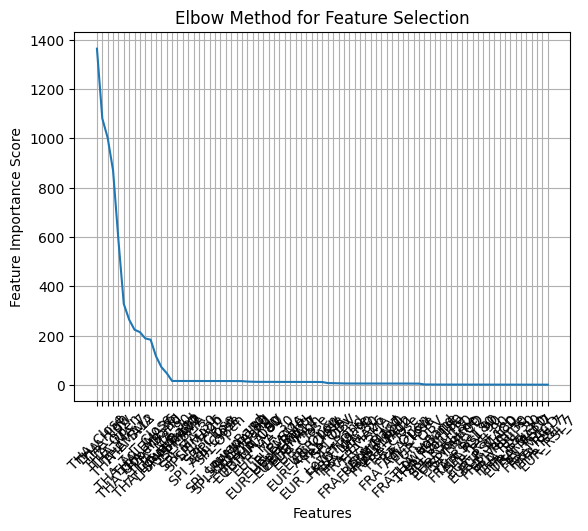

In [16]:
# Extract features and scores
features = feature_scores['feature'].to_numpy()
scores = feature_scores['score'].to_numpy()

# Sort together by scores (descending)
sorted_data = pd.DataFrame({'feature': features, 'score': scores})
sorted_data = sorted_data.sort_values(by='score', ascending=False)

# Extract sorted features and scores
sorted_features = sorted_data['feature'].to_numpy()
sorted_scores = sorted_data['score'].to_numpy()

# Plot the elbow graph
plt.plot(sorted_features, sorted_scores)
plt.xlabel("Features")
plt.ylabel("Feature Importance Score")
plt.title("Elbow Method for Feature Selection")
plt.xticks(rotation=45)  # Rotate feature names for readability

# Optional: Add a grid for better visualization
plt.grid(True)

plt.show()

In [20]:
# Filter features starting with 'THA_'
tha_features = [col for col in train_data.columns if col.startswith('THA_')]
df_filtered = train_data[tha_features]

# Define features (X) and target (y)
X = df_filtered.drop(columns=['THA_NextDay_Close'])
y = df_filtered['THA_NextDay_Close']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models (excluding ARIMA)
models = {
    'Random Forest': RandomForestRegressor(),
    'k-Nearest Neighbors': KNeighborsRegressor(),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Multi-layer Perceptron': MLPRegressor(max_iter=1000),
    'XGBoost': XGBRegressor(),
    'Support Vector Machine (Poly)': SVR(kernel='poly'),
    'Support Vector Machine (Radial)': SVR(kernel='rbf'),
    'Support Vector Machine (Linear)': SVR(kernel='linear')
}

# Function to calculate and print evaluation metrics
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{model_name}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")


# Loop through models, train, and evaluate
for model_name, model in models.items():
    model.fit(X_train, y_train)
    evaluate_model(model_name, model, X_test, y_test)


# Example LSTM implementation (adjust hyperparameters as needed)
# Define features (X) and target (y)
X_train = df_filtered.drop('THA_NextDay_Close', axis=1)  # Drop target variable from features
y_train = df_filtered['THA_NextDay_Close']

# Get the number of features dynamically
n_features = X_train.shape[1]

# Define the LSTM model with dynamic input shape
model = Sequential()
model.add(Input(shape=(n_features, 1)))  # Define input shape here
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
evaluate_model('LSTM', model, X_test, y_test)

Random Forest: MSE = 1.7035, RMSE = 1.3052, MAE = 0.7885
k-Nearest Neighbors: MSE = 2.2569, RMSE = 1.5023, MAE = 0.9749
Linear Regression: MSE = 1.6422, RMSE = 1.2815, MAE = 0.7633
Gradient Boosting: MSE = 1.7412, RMSE = 1.3195, MAE = 0.8053
Decision Tree: MSE = 2.5059, RMSE = 1.5830, MAE = 1.0459
Multi-layer Perceptron: MSE = 2.0624, RMSE = 1.4361, MAE = 0.8723
XGBoost: MSE = 1.9694, RMSE = 1.4034, MAE = 0.8629
Support Vector Machine (Poly): MSE = 14.9405, RMSE = 3.8653, MAE = 2.4632
Support Vector Machine (Radial): MSE = 3.7796, RMSE = 1.9441, MAE = 1.1282
Support Vector Machine (Linear): MSE = 2.2261, RMSE = 1.4920, MAE = 0.8778
Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3653.6035 - val_loss: 2758.2607
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2526.7356 - val_loss: 2240.1394
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2176.7769 - val_loss: 1863.5011
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1774.1113 - val_los

In [ ]:
# All Features except FK_DT_Date
# # Random Forest: MSE = 1.7035, RMSE = 1.3052, MAE = 0.7885
# k-Nearest Neighbors: MSE = 2.2569, RMSE = 1.5023, MAE = 0.9749
# Linear Regression: MSE = 1.6422, RMSE = 1.2815, MAE = 0.7633
# Gradient Boosting: MSE = 1.7412, RMSE = 1.3195, MAE = 0.8053
# Decision Tree: MSE = 2.5059, RMSE = 1.5830, MAE = 1.0459
# Multi-layer Perceptron: MSE = 2.0624, RMSE = 1.4361, MAE = 0.8723
# XGBoost: MSE = 1.9694, RMSE = 1.4034, MAE = 0.8629
# Support Vector Machine (Poly): MSE = 14.9405, RMSE = 3.8653, MAE = 2.4632
# Support Vector Machine (Radial): MSE = 3.7796, RMSE = 1.9441, MAE = 1.1282
# Support Vector Machine (Linear): MSE = 2.2261, RMSE = 1.4920, MAE = 0.8778
# LSTM: MSE = 2.5670, RMSE = 1.6022, MAE = 1.1268

In [29]:
# Get top features based on F-value
top_features = list(feature_scores.head(30)['feature'])  # Adjust the number of features (k) as needed

# Define features (X) for model training using selected features
X = train_data[top_features]

# Define target variable (y) for model training and evaluation
y = train_data['THA_NextDay_Close']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models (excluding ARIMA)
models = {
    'Random Forest': RandomForestRegressor(),
    'k-Nearest Neighbors': KNeighborsRegressor(),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Multi-layer Perceptron': MLPRegressor(max_iter=1000),
    'XGBoost': XGBRegressor(),
    'Support Vector Machine (Poly)': SVR(kernel='poly'),
    'Support Vector Machine (Radial)': SVR(kernel='rbf'),
    'Support Vector Machine (Linear)': SVR(kernel='linear')
}

# Function to calculate and print evaluation metrics
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{model_name}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")


# Loop through models, train, and evaluate
for model_name, model in models.items():
    model.fit(X_train, y_train)
    evaluate_model(model_name, model, X_test, y_test)


# Example LSTM implementation (adjust hyperparameters as needed)
# Define features (X) and target (y)
X_train = train_data_filtered.drop('THA_NextDay_Close', axis=1)  # Drop target variable from features
y_train = train_data_filtered['THA_NextDay_Close']

# Get the number of features dynamically
n_features = X_train.shape[1]

# Define the LSTM model with dynamic input shape
model = Sequential()
model.add(Input(shape=(n_features, 1)))  # Define input shape here
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
evaluate_model('LSTM', model, X_test, y_test)

Random Forest: MSE = 1.7210, RMSE = 1.3119, MAE = 0.7858
k-Nearest Neighbors: MSE = 1.9707, RMSE = 1.4038, MAE = 0.8105
Linear Regression: MSE = 1.6077, RMSE = 1.2680, MAE = 0.7531
Gradient Boosting: MSE = 1.7464, RMSE = 1.3215, MAE = 0.8050
Decision Tree: MSE = 2.6304, RMSE = 1.6219, MAE = 1.0556
Multi-layer Perceptron: MSE = 2.1446, RMSE = 1.4644, MAE = 0.8781
XGBoost: MSE = 1.9582, RMSE = 1.3994, MAE = 0.8317
Support Vector Machine (Poly): MSE = 49.0350, RMSE = 7.0025, MAE = 5.6358
Support Vector Machine (Radial): MSE = 3.8672, RMSE = 1.9665, MAE = 1.1684
Support Vector Machine (Linear): MSE = 2.1745, RMSE = 1.4746, MAE = 0.8863
Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 3646.8347 - val_loss: 2928.7791
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2707.9172 - val_loss: 2393.9688
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2206.9448 - val_loss: 1995.3617
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1824.9877 - val_

In [31]:
# Using top 30 Features based on Fscore
# Random Forest: MSE = 1.7210, RMSE = 1.3119, MAE = 0.7858
# k-Nearest Neighbors: MSE = 1.9707, RMSE = 1.4038, MAE = 0.8105
# Linear Regression: MSE = 1.6077, RMSE = 1.2680, MAE = 0.7531
# Gradient Boosting: MSE = 1.7464, RMSE = 1.3215, MAE = 0.8050
# Decision Tree: MSE = 2.6304, RMSE = 1.6219, MAE = 1.0556
# Multi-layer Perceptron: MSE = 2.1446, RMSE = 1.4644, MAE = 0.8781
# XGBoost: MSE = 1.9582, RMSE = 1.3994, MAE = 0.8317
# Support Vector Machine (Poly): MSE = 49.0350, RMSE = 7.0025, MAE = 5.6358
# Support Vector Machine (Radial): MSE = 3.8672, RMSE = 1.9665, MAE = 1.1684
# Support Vector Machine (Linear): MSE = 2.1745, RMSE = 1.4746, MAE = 0.8863
# LSTM: MSE = 1069.6376, RMSE = 32.7053, MAE = 28.0060

In [1]:
# Define features (X) for model training using selected features
X = train_data[filtered_features_Norm]

# Define target variable (y) for model training and evaluation
y = train_data['THA_NextDay_Close']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models (excluding ARIMA)
models = {
    'Random Forest': RandomForestRegressor(),
    'k-Nearest Neighbors': KNeighborsRegressor(),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Multi-layer Perceptron': MLPRegressor(max_iter=1000),
    'XGBoost': XGBRegressor(),
    'Support Vector Machine (Poly)': SVR(kernel='poly'),
    'Support Vector Machine (Radial)': SVR(kernel='rbf'),
    'Support Vector Machine (Linear)': SVR(kernel='linear')
}

# Function to calculate and print evaluation metrics
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{model_name}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")


# Loop through models, train, and evaluate
for model_name, model in models.items():
    model.fit(X_train, y_train)
    evaluate_model(model_name, model, X_test, y_test)

# Example LSTM implementation (adjust hyperparameters as needed)
# Reshape data for LSTM input
X_train_LSTM = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_LSTM = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))  # Reshape test data as well

# Define the LSTM model with dynamic input shape
model = Sequential()
model.add(Input(shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))  # Define input shape based on reshaped data
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_LSTM, y_train, epochs=100, batch_size=32, validation_data=(X_test_LSTM, y_test))
evaluate_model('LSTM', model, X_test_LSTM, y_test)

NameError: name 'train_data' is not defined